**RECOMENDER SYSTEM FOR TOLOLI SHOP ONLINE**

In [1]:
pip install neattext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 114 kB 5.1 MB/s 


In [2]:
# Load EDA Packages
import pandas as pd
import neattext.functions as nfx

In [3]:
# Load ML/Rc Packages
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity,linear_kernel

In [4]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats
# Visualization
import seaborn as sns
# Similarity
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
# using os and zipfile library to prepare the dataset
import os
import zipfile
import json

# library for data processing
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

# library to make the recommendation system model
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

# library for evaluate the machine learning model
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score


In [6]:
# Read in data
ratings=pd.read_csv('tololirate.csv')
# Take a look at the data
ratings.head()


,user_id,item_id,rate,price
0,500,1664626921-9,3.0,300.0
1,248,1664627074-28,2.0,250.0
2,700,1664627163-39,5.0,250.0
3,200,1664626864-2,1.0,250.0
4,607,1664627066-27,4.0,250.0


In [7]:
# Get the dataset information
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  106 non-null    int64  
 1   item_id  106 non-null    object 
 2   rate     105 non-null    float64
 3   price    105 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.4+ KB


**The ratings are from 105 users on 106 games. The rating has ten unique values from 1 to 5.**

In [8]:
# Number of users
print('The ratings dataset has', ratings['user_id'].nunique(), 'unique users')
# Number of mgames
print('The ratings dataset has', ratings['item_id'].nunique(), 'unique games')
# Number of ratings
print('The ratings dataset has', ratings['rate'].nunique(), 'unique ratings')
# Number of ratings
print('The ratings dataset has', ratings['price'].nunique(), 'unique price')
# List of unique ratings
print('The unique ratings are', sorted(ratings['rate'].unique()))

The ratings dataset has 59 unique users
The ratings dataset has 57 unique games
The ratings dataset has 5 unique ratings
The ratings dataset has 2 unique price
The unique ratings are [1.0, 2.0, 3.0, 4.0, 5.0, nan]


**Let’s read in the games data to get the games names.**

In [9]:
# Read in data
gamesdata = pd.read_csv('tololishop.csv')
# Take a look at the data
gamesdata.head()

,item_id,web-scraper-start-url,item-href,name,genre,operating systems
0,1664626921-9,https://tololishop.com/store/rndanyengwa/,https://tololishop.com/product/arsenal-ps4-ski...,Arsenal PS4 Skin for Console,Sport,"macOS, Microsoft Windows"
1,1664627074-28,https://tololishop.com/store/rndanyengwa/,https://tololishop.com/product/arsenal-xbox-on...,Arsenal Xbox One Skin,Sport,IBM PC
2,1664627163-39,https://tololishop.com/store/rndanyengwa/,https://tololishop.com/product/arsenal-xbox-on...,Arsenal Xbox One X Skin,Sport,Microsoft Windows
3,1664626864-2,https://tololishop.com/store/rndanyengwa/,https://tololishop.com/product/barcelona-ps4-s...,Barcelona PS4 Skin for Console,Sport,"Windows, Mac"
4,1664627066-27,https://tololishop.com/store/rndanyengwa/,https://tololishop.com/product/barcelona-xbox-...,Barcelona Xbox One Skin,Sport,Microsoft Windows


**Using item_id as the matching key, we appended games information to the rating dataset and named it df. So now we have the games title and games rating in the same dataset!**

In [10]:
# Merge ratings and movies datasets
df = pd.merge(ratings, gamesdata, on='item_id', how='inner')
# Take a look at the data
df.head()

,user_id,item_id,rate,price,web-scraper-start-url,item-href,name,genre,operating systems
0,500,1664626921-9,3.0,300.0,https://tololishop.com/store/rndanyengwa/,https://tololishop.com/product/arsenal-ps4-ski...,Arsenal PS4 Skin for Console,Sport,"macOS, Microsoft Windows"
1,500,1664626921-9,3.0,300.0,https://tololishop.com/store/rndanyengwa/,https://tololishop.com/product/arsenal-ps4-ski...,Arsenal PS4 Skin for Console,Sport,"macOS, Microsoft Windows"
2,101,1664626921-9,3.0,300.0,https://tololishop.com/store/rndanyengwa/,https://tololishop.com/product/arsenal-ps4-ski...,Arsenal PS4 Skin for Console,Sport,"macOS, Microsoft Windows"
3,101,1664626921-9,3.0,300.0,https://tololishop.com/store/rndanyengwa/,https://tololishop.com/product/arsenal-ps4-ski...,Arsenal PS4 Skin for Console,Sport,"macOS, Microsoft Windows"
4,248,1664627074-28,2.0,250.0,https://tololishop.com/store/rndanyengwa/,https://tololishop.com/product/arsenal-xbox-on...,Arsenal Xbox One Skin,Sport,IBM PC


**Explolation Data Analysis (EDA)**

Let's explore the data a bit and get a look at some of the best rated games.

To do that, we first group the games by (names)title, count the number of ratings, and keep only the games with greater than 0 ratings.

The average ratings for the games are calculated as well.

In [11]:
# Aggregate by game
agg_ratings = df.groupby('name').agg(mean_rating = ('rate', 'mean'),
                                                number_of_ratings = ('rate', 'count')).reset_index()
# Keep the games with over 0 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>0]
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 0 to 40
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               41 non-null     object 
 1   mean_rating        41 non-null     float64
 2   number_of_ratings  41 non-null     int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ KB


**Now, lets see the most popular games and their ratings.**

In [12]:
# Check popular games
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,name,mean_rating,number_of_ratings
31,Manchester United PS4 Pro Skin,2.0,37
28,Liverpool PS4 Skin for Console,3.0,28
3,Barcelona PS4 Skin for Console,1.0,21
11,Chelsea PS4 Skin for Console and 2 Touchpads,5.0,19
14,Deadpool PS4 Skin,5.0,16


In [13]:
#setting the number of ratings column:
ratings['number_of_ratings'] = pd.DataFrame(df.groupby('name')['rate'].count())
ratings.head()


,user_id,item_id,rate,price,number_of_ratings
0,500,1664626921-9,3.0,300.0,NaN
1,248,1664627074-28,2.0,250.0,NaN
2,700,1664627163-39,5.0,250.0,NaN
3,200,1664626864-2,1.0,250.0,NaN
4,607,1664627066-27,4.0,250.0,NaN


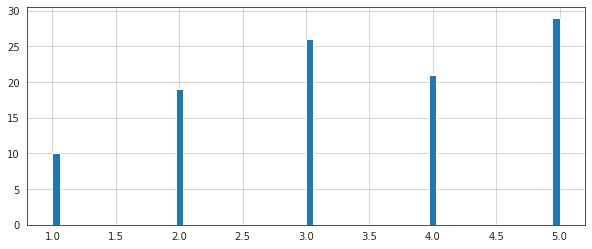

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
#show number of rates in histograms:
plt.figure(figsize=(10,4))
ratings['rate'].hist(bins=70)

 **Let’s use a jointplot to check the correlation between the average rating and the number of ratings.**
 The average rating distribution shows that most movies in the dataset have an average rating of around 5.

The number of rating distribution shows that most games have less than 5 ratings.

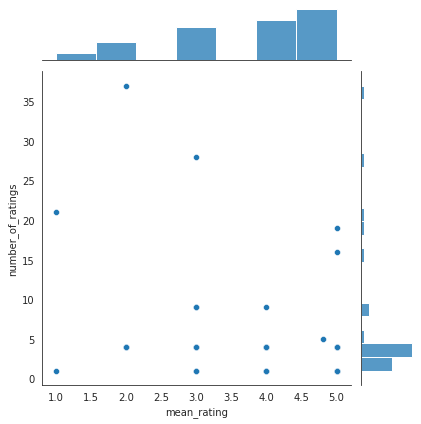

In [15]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

# FILTER games with with the user-rating level dataframe.

In [16]:
# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['name']], on='name', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245 entries, 0 to 244
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                245 non-null    int64  
 1   item_id                245 non-null    object 
 2   rate                   245 non-null    float64
 3   price                  245 non-null    float64
 4   web-scraper-start-url  245 non-null    object 
 5   item-href              245 non-null    object 
 6   name                   245 non-null    object 
 7   genre                  245 non-null    object 
 8   operating systems      245 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 19.1+ KB


In [17]:
# Number of games
print('The ratings dataset has', df_GT100['item_id'].nunique(), 'unique games')
# Number of ratings
print('The ratings dataset has', df_GT100['rate'].nunique(), 'unique ratings')
# List of unique ratings
print('The unique ratings are', sorted(df_GT100['rate'].unique()))

The ratings dataset has 56 unique games
The ratings dataset has 5 unique ratings
The unique ratings are [1.0, 2.0, 3.0, 4.0, 5.0]


##  **Create User-Game Matrix**

**Transforming the dataset into a matrix format. The rows of the matrix are users, and the columns of the matrix are games. The value of the matrix is the user rating of the games if there is a rating. Otherwise, it shows ‘NaN’.**

In [18]:
# Create user-item matrix
matrix = df_GT100.pivot_table(index='user_id', columns='name', values='rate')
matrix.head()

name,Arsenal PS4 Skin for Console,Arsenal Xbox One Skin,Arsenal Xbox One X Skin,Barcelona PS4 Skin for Console,Barcelona Xbox One Skin,Batman PS4 Pro Skin,Batman PS4 Slim Skin,Batman Xbox One Skin,Batman Xbox One X Skin,Bush PS4 Pro Skin,...,Manchester United PS4 Pro Skin,Manchester United PS4 Slim Skin,Manchester United Xbox One X Skin,Mortal Kombat PS4 Slim Skin,Real Madrid PS4 Pro Skin,Real Madrid PS4 Skin,Real Madrid PS4 Slim Skin,Real Madrid Xbox One Skin,Smoking Girl Xbox One S Skin,Street Fighter PS4 Pro Skin
user_id,,,,,,,,,,,,,,,,,,,,,
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN
101,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,3.0,NaN,NaN,NaN,5.0,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN


# **Data Normalization**

**Since some people tend to give a higher rating than others, we normalize the rating by extracting the average rating of each user.**

In [19]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

name,Arsenal PS4 Skin for Console,Arsenal Xbox One Skin,Arsenal Xbox One X Skin,Barcelona PS4 Skin for Console,Barcelona Xbox One Skin,Batman PS4 Pro Skin,Batman PS4 Slim Skin,Batman Xbox One Skin,Batman Xbox One X Skin,Bush PS4 Pro Skin,...,Manchester United PS4 Pro Skin,Manchester United PS4 Slim Skin,Manchester United Xbox One X Skin,Mortal Kombat PS4 Slim Skin,Real Madrid PS4 Pro Skin,Real Madrid PS4 Skin,Real Madrid PS4 Slim Skin,Real Madrid Xbox One Skin,Smoking Girl Xbox One S Skin,Street Fighter PS4 Pro Skin
user_id,,,,,,,,,,,,,,,,,,,,,
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
101,-0.285714,NaN,NaN,NaN,0.714286,NaN,NaN,NaN,NaN,NaN,...,-1.285714,NaN,NaN,-0.285714,NaN,NaN,NaN,1.714286,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.333333,NaN,NaN,-0.333333,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


After normalization, the games with a rating less than the user’s average rating get a negative value, and the games with a rating more than the user’s average rating get a positive value.

#  SIMILARITIES

 **Identify Similar Users**

**we will calculate the user similarity matrix using Pearson correlation.**

In [20]:
# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

user_id,100,101,102,103,104,105,106,107,119,120,...,567,578,579,607,624,633,678,679,700,741
user_id,,,,,,,,,,,,,,,,,,,,,
100,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Since cosine_similarity does not take missing values, we need to impute the missing values with 0s before the calculation.**

In [21]:
# User similarity matrix using cosine similarity
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

array([[ 1.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  1.       , -0.3003757, ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       , -0.3003757,  1.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  1.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]])

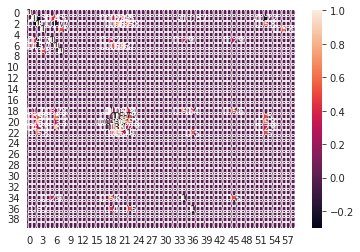

In [22]:
import seaborn as sns
sns.heatmap(user_similarity_cosine[0:40],annot=True)

**How to find similar users**

We first need to exclude user ID 1 from the similar user list and decide the number of similar users.

In [78]:
# Pick a user ID
picked_user_id = 101
# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_user_id, inplace=True)
# Take a look at the data
user_similarity.head()

user_id,100,101,102,103,104,105,106,107,119,120,...,567,578,579,607,624,633,678,679,700,741
user_id,,,,,,,,,,,,,,,,,,,,,
100,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
104,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
# Number of similar users
n = 10
# User similarity threashold
user_similarity_threshold = 0.3
# Get top n similar users
similar_users = user_similarity[user_similarity[picked_user_id]>user_similarity_threshold][picked_user_id].sort_values(ascending=False)[:n]
# Print out top n similar users
print(f'The similar users for user {picked_user_id} are', similar_users)

The similar users for user 101 are user_id
102    1.0
105    1.0
106    1.0
127    1.0
136    1.0
137    1.0
138    1.0
139    1.0
200    1.0
500    1.0
Name: 101, dtype: float64


**After setting the number of similar users and similarity threshold, we sort the user similarity value from the highest and lowest, then printed out the most similar users’ ID and the Pearson correlation value.**

# **Narrow Down Item Pool**

In [81]:
# games that the target user has played
picked_user_id_played = matrix_norm[matrix_norm.index == picked_user_id].dropna(axis=1, how='all')
picked_user_id_played

name,Arsenal PS4 Skin for Console,Barcelona Xbox One Skin,Bush PS4 Slim Skin,Liverpool PS4 Skin,Manchester United PS4 Pro Skin,Mortal Kombat PS4 Slim Skin,Real Madrid Xbox One Skin
user_id,,,,,,,
101,-0.285714,0.714286,-0.285714,-0.285714,-1.285714,-0.285714,1.714286


In [82]:
# s that similar users watched. Remove movies that none of the similar users have watched
similar_user_games = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_games

name,Arsenal PS4 Skin for Console,Arsenal Xbox One Skin,Arsenal Xbox One X Skin,Barcelona PS4 Skin for Console,Bush PS4 Slim Skin,Chelsea PS4 Skin for Console and 2 Touchpads,Deadpool PS4 Skin,Deadpool Xbox One X Skin,Manchester United PS4 Pro Skin,Mortal Kombat PS4 Slim Skin,Real Madrid PS4 Pro Skin,Real Madrid Xbox One Skin
user_id,,,,,,,,,,,,
102,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN,-0.333333,-0.333333
105,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,-1.333333,NaN,0.666667
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,-1.333333,NaN,0.666667,NaN
127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
136,NaN,NaN,NaN,-1.666667,NaN,NaN,2.333333,NaN,-0.666667,NaN,NaN,NaN
137,NaN,NaN,NaN,NaN,NaN,1.500000,NaN,NaN,-1.500000,NaN,NaN,NaN
138,NaN,-1.0,NaN,NaN,NaN,2.000000,NaN,NaN,-1.000000,NaN,NaN,NaN
139,NaN,NaN,1.0,NaN,NaN,1.000000,NaN,NaN,-2.000000,NaN,NaN,NaN
200,NaN,NaN,NaN,-1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
# Games that similar users played. Remove gamess that none of the similar users have played
similar_user_games = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_games

name,Arsenal PS4 Skin for Console,Arsenal Xbox One Skin,Arsenal Xbox One X Skin,Barcelona PS4 Skin for Console,Bush PS4 Slim Skin,Chelsea PS4 Skin for Console and 2 Touchpads,Deadpool PS4 Skin,Deadpool Xbox One X Skin,Manchester United PS4 Pro Skin,Mortal Kombat PS4 Slim Skin,Real Madrid PS4 Pro Skin,Real Madrid Xbox One Skin
user_id,,,,,,,,,,,,
102,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN,-0.333333,-0.333333
105,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,-1.333333,NaN,0.666667
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,-1.333333,NaN,0.666667,NaN
127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
136,NaN,NaN,NaN,-1.666667,NaN,NaN,2.333333,NaN,-0.666667,NaN,NaN,NaN
137,NaN,NaN,NaN,NaN,NaN,1.500000,NaN,NaN,-1.500000,NaN,NaN,NaN
138,NaN,-1.0,NaN,NaN,NaN,2.000000,NaN,NaN,-1.000000,NaN,NaN,NaN
139,NaN,NaN,1.0,NaN,NaN,1.000000,NaN,NaN,-2.000000,NaN,NaN,NaN
200,NaN,NaN,NaN,-1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**We will drop the games that user ID 101 played from the similar user game list. errors='ignore' drops columns if they exist without giving an error message.**

In [85]:
# Remove the watched movie from the movie list
similar_user_games.drop(picked_user_id_played.columns,axis=1, inplace=True, errors='ignore')
# Take a look at the data
similar_user_games

name,Arsenal Xbox One Skin,Arsenal Xbox One X Skin,Barcelona PS4 Skin for Console,Chelsea PS4 Skin for Console and 2 Touchpads,Deadpool PS4 Skin,Deadpool Xbox One X Skin,Real Madrid PS4 Pro Skin
user_id,,,,,,,
102,NaN,NaN,NaN,0.666667,NaN,NaN,-0.333333
105,NaN,NaN,NaN,NaN,0.666667,NaN,NaN
106,NaN,NaN,NaN,NaN,NaN,0.666667,0.666667
127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,NaN,NaN,-1.666667,NaN,2.333333,NaN,NaN
137,NaN,NaN,NaN,1.500000,NaN,NaN,NaN
138,-1.0,NaN,NaN,2.000000,NaN,NaN,NaN
139,NaN,1.0,NaN,1.000000,NaN,NaN,NaN
200,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN


# **Recommend Games**

**we will decide which games to recommend to the target user. The recommended items are determined by the weighted average of user similarity score and game rating. The movie ratings are weighted by the similarity scores, so the users with higher similarity get higher weights**

In [86]:
# A dictionary to store item scores
item_score = {}
# Loop through items
for i in similar_user_games.columns:
  # Get the ratings for game i
  game_rating = similar_user_games[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the game has rating
    if pd.isna(game_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the game rating
      score = similar_users[u] * game_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count
# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['game', 'game_score'])
    
# Sort the game by score
ranked_item_score = item_score.sort_values(by='game_score', ascending=False)
# Select top games
m = 10
ranked_item_score.head(m)

,game,game_score
4,Deadpool PS4 Skin,1.500000
3,Chelsea PS4 Skin for Console and 2 Touchpads,1.291667
1,Arsenal Xbox One X Skin,1.000000
5,Deadpool Xbox One X Skin,0.666667
6,Real Madrid PS4 Pro Skin,0.166667
0,Arsenal Xbox One Skin,-1.000000
2,Barcelona PS4 Skin for Console,-1.333333


**Let's create a ratings dataframe with average rating:**

In [98]:
df.groupby('name')['rate'].mean().sort_values(ascending=False).head()

name
Street Fighter PS4 Pro Skin    5.0
Liverpool Xbox One X Skin      5.0
FC Barcelona PS4 Pro Skin      5.0
GTA V Xbox One Skin            5.0
Deadpool PS4 Skin              5.0
Name: rate, dtype: float64

In [99]:
df.groupby('name')['rate'].count().sort_values(ascending=False).head()

name
Manchester United PS4 Pro Skin                  37
Liverpool PS4 Skin for Console                  28
Barcelona PS4 Skin for Console                  21
Chelsea PS4 Skin for Console and 2 Touchpads    19
Deadpool PS4 Skin                               16
Name: rate, dtype: int64

In [100]:
ratings = pd.DataFrame(df.groupby('name')['rate'].mean())
ratings.head()

,rate
name,
Arsenal PS4 Skin for Console,3.0
Arsenal Xbox One Skin,2.0
Arsenal Xbox One X Skin,5.0
Barcelona PS4 Skin for Console,1.0
Barcelona Xbox One Skin,4.0


# **Predict Scores**
**If the goal is to choose the recommended items, having the rank of the items is enough. However, if the goal is to predict the user’s rating, we need to add the user’s average game rating score back to the game score**.

In [87]:
# Average rating for the picked user
avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]
# Print the average game rating for user 1
print(f'The average games rating for user {picked_userid} is {avg_rating:.2f}')


The average games rating for user 101 is 3.29


**The average games rating for user 101 is 3.29, so we add 3.29 back to the movie score.**

In [88]:
# Calcuate the predicted rating
ranked_item_score['predicted_rating'] = ranked_item_score['game_score'] + avg_rating
# Take a look at the data
ranked_item_score.head(m)

,game,game_score,predicted_rating
4,Deadpool PS4 Skin,1.500000,4.785714
3,Chelsea PS4 Skin for Console and 2 Touchpads,1.291667,4.577381
1,Arsenal Xbox One X Skin,1.000000,4.285714
5,Deadpool Xbox One X Skin,0.666667,3.952381
6,Real Madrid PS4 Pro Skin,0.166667,3.452381
0,Arsenal Xbox One Skin,-1.000000,2.285714
2,Barcelona PS4 Skin for Console,-1.333333,1.952381


**We can see that the top recommended games all have predicted ratings greater than 3.29.**

In [97]:
#reading the dataset name of the games
gamesdata['name']

item_id
1664626921-9       Arsenal PS4 Skin for Console
1664627074-28             Arsenal Xbox One Skin
1664627163-39           Arsenal Xbox One X Skin
1664626864-2     Barcelona PS4 Skin for Console
1664627066-27           Barcelona Xbox One Skin
                              ...              
1664626937-13    Manchester United PS4 Pro Skin
1664626937-13    Manchester United PS4 Pro Skin
1664626937-13    Manchester United PS4 Pro Skin
1664626864-3     Barcelona PS4 Skin for Console
1664626864-3     Barcelona PS4 Skin for Console
Name: name, Length: 106, dtype: object

# **Let's create a ratings dataframe with average rating and number of ratings:**

In [95]:
df.head()

,user_id,rate,price,number_of_ratings
name,,,,
Arsenal PS4 Skin for Console,500,3.0,300.0,NaN
Arsenal PS4 Skin for Console,500,3.0,300.0,NaN
Arsenal PS4 Skin for Console,101,3.0,300.0,NaN
Arsenal PS4 Skin for Console,101,3.0,300.0,NaN
Arsenal Xbox One Skin,248,2.0,250.0,NaN


In [92]:
#dir(nfx)

In [36]:
# Clean Text:stopwords,special charactor
df['clean_name'] = df['name'].apply(nfx.remove_stopwords)

In [37]:
# Clean Text:stopwords,special charactor
df['clean_name'] = df['clean_name'].apply(nfx.remove_special_characters)

In [38]:
df[['name','clean_name']]

,name,clean_name
0,Arsenal PS4 Skin for Console,Arsenal PS4 Skin Console
1,Arsenal PS4 Skin for Console,Arsenal PS4 Skin Console
2,Arsenal PS4 Skin for Console,Arsenal PS4 Skin Console
3,Arsenal PS4 Skin for Console,Arsenal PS4 Skin Console
4,Arsenal Xbox One Skin,Arsenal Xbox Skin
...,...,...
241,Barcelona PS4 Skin for Console,Barcelona PS4 Skin Console
242,Barcelona PS4 Skin for Console,Barcelona PS4 Skin Console
243,Chelsea PS4 Skin for Console and 2 Touchpads,Chelsea PS4 Skin Console 2 Touchpads
244,Chelsea PS4 Skin for Console and 2 Touchpads,Chelsea PS4 Skin Console 2 Touchpads


In [102]:
name_indices

name
Arsenal PS4 Skin for Console                      0
Arsenal PS4 Skin for Console                      1
Arsenal PS4 Skin for Console                      2
Arsenal PS4 Skin for Console                      3
Arsenal Xbox One Skin                             4
                                               ... 
Barcelona PS4 Skin for Console                  241
Barcelona PS4 Skin for Console                  242
Chelsea PS4 Skin for Console and 2 Touchpads    243
Chelsea PS4 Skin for Console and 2 Touchpads    244
Chelsea PS4 Skin for Console and 2 Touchpads    245
Length: 246, dtype: int64

**Recommending Similar Games**

Create a matrix that has the item ids on one access and the game title on another axis. Each cell will then consist of the rating the item gave to that game. Note there will be a lot of NaN values, because most people have not seen most of the games.

In [59]:
# Create user-item matrix
gamemat = df.pivot_table(index='user_id',columns='name')
gamemat.head()

price                        \
name    Arsenal PS4 Skin for Console Arsenal Xbox One Skin   
user_id                                                      
100                              NaN                   NaN   
101                            300.0                   NaN   
102                              NaN                   NaN   
103                              NaN                   NaN   
104                              NaN                   NaN   

                                                                \
name    Arsenal Xbox One X Skin Barcelona PS4 Skin for Console   
user_id                                                          
100                         NaN                            NaN   
101                         NaN                            NaN   
102                         NaN                            NaN   
103                         NaN                            NaN   
104                         NaN                            NaN   

                                                                          \
name    Barcelona Xbox One Skin Batman PS4 Pro Skin Batman PS4 Slim Skin   
user_id                                                                    
100                         NaN                 NaN                  NaN   
101                       250.0                 NaN                  NaN   
102                         NaN                 NaN                  NaN   
103                         NaN                 NaN                  NaN   
104                         NaN                 NaN                  NaN   

                                                                       ...  \
name    Batman Xbox One Skin Batman Xbox One X Skin Bush PS4 Pro Skin  ...   
user_id                                                                ...   
100                      NaN                    NaN               NaN  ...   
101                      NaN                    NaN               NaN  ...   
102                      NaN                    NaN               NaN  ...   
103                      NaN                    NaN               NaN  ...   
104                      NaN                    NaN               NaN  ...   

                                  rate                                  \
name    Manchester United PS4 Pro Skin Manchester United PS4 Slim Skin   
user_id                                                                  
100                                NaN                             NaN   
101                                2.0                             NaN   
102                                NaN                             NaN   
103                                NaN                             NaN   
104                                NaN                             NaN   

                                                                       \
name    Manchester United Xbox One X Skin Mortal Kombat PS4 Slim Skin   
user_id                                                                 
100                                   2.0                         NaN   
101                                   NaN                         3.0   
102                                   NaN                         NaN   
103                                   NaN                         NaN   
104                                   NaN                         NaN   

                                                       \
name    Real Madrid PS4 Pro Skin Real Madrid PS4 Skin   
user_id                                                 
100                          NaN                  NaN   
101                          NaN                  NaN   
102                          4.0                  NaN   
103                          NaN                  5.0   
104                          NaN                  NaN   

                                                             \
name    Real Madrid PS4 Slim Skin Real Madrid Xbox One Skin   
user_id   

In [60]:
# Normalize user-item matrix
gamemat_norm = gamemat.subtract(gamemat.mean(axis=1), axis = 'rows')
gamemat_norm.head()

price                        \
name    Arsenal PS4 Skin for Console Arsenal Xbox One Skin   
user_id                                                      
100                              NaN                   NaN   
101                       159.071429                   NaN   
102                              NaN                   NaN   
103                              NaN                   NaN   
104                              NaN                   NaN   

                                                                \
name    Arsenal Xbox One X Skin Barcelona PS4 Skin for Console   
user_id                                                          
100                         NaN                            NaN   
101                         NaN                            NaN   
102                         NaN                            NaN   
103                         NaN                            NaN   
104                         NaN                            NaN   

                                                                          \
name    Barcelona Xbox One Skin Batman PS4 Pro Skin Batman PS4 Slim Skin   
user_id                                                                    
100                         NaN                 NaN                  NaN   
101                  109.071429                 NaN                  NaN   
102                         NaN                 NaN                  NaN   
103                         NaN                 NaN                  NaN   
104                         NaN                 NaN                  NaN   

                                                                       ...  \
name    Batman Xbox One Skin Batman Xbox One X Skin Bush PS4 Pro Skin  ...   
user_id                                                                ...   
100                      NaN                    NaN               NaN  ...   
101                      NaN                    NaN               NaN  ...   
102                      NaN                    NaN               NaN  ...   
103                      NaN                    NaN               NaN  ...   
104                      NaN                    NaN               NaN  ...   

                                  rate                                  \
name    Manchester United PS4 Pro Skin Manchester United PS4 Slim Skin   
user_id                                                                  
100                                NaN                             NaN   
101                        -138.928571                             NaN   
102                                NaN                             NaN   
103                                NaN                             NaN   
104                                NaN                             NaN   

                                                                       \
name    Manchester United Xbox One X Skin Mortal Kombat PS4 Slim Skin   
user_id                                                                 
100                                -149.5                         NaN   
101                                   NaN                 -137.928571   
102                                   NaN                         NaN   
103                                   NaN                         NaN   
104                                   NaN                         NaN   

                                                       \
name    Real Madrid PS4 Pro Skin Real Madrid PS4 Skin   
user_id                                                 
100                          NaN                  NaN   
101                          NaN                  NaN   
102                  -148.166667                  NaN   
103                          NaN              -147.25   
104                          NaN                  NaN   

                                                             \
name    Real Madrid PS4 Slim Skin Real Madrid Xbox One Skin   
user_id   

In [61]:
# User similarity matrix using Pearson correlation
user_similarity = gamemat_norm.T.corr()
user_similarity.head()

user_id,100,101,102,103,104,105,106,107,119,120,...,567,578,579,607,624,633,678,679,700,741
user_id,,,,,,,,,,,,,,,,,,,,,
100,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
102,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
104,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# User similarity matrix using cosine similarity
user_similarity_cosine = cosine_similarity(gamemat_norm.fillna(1))
user_similarity_cosine

array([[1.00000000e+00, 3.28173998e-04, 5.31120509e-04, ...,
        5.94532077e-04, 7.26304217e-04, 9.74082588e-04],
       [3.28173998e-04, 1.00000000e+00, 2.32339231e-01, ...,
        3.69012878e-04, 4.52416697e-04, 6.08808318e-04],
       [5.31120509e-04, 2.32339231e-01, 1.00000000e+00, ...,
        5.97214613e-04, 7.29581310e-04, 9.78477660e-04],
       ...,
       [5.94532077e-04, 3.69012878e-04, 5.97214613e-04, ...,
        1.00000000e+00, 8.16687521e-04, 1.09530012e-03],
       [7.26304217e-04, 4.52416697e-04, 7.29581310e-04, ...,
        8.16687521e-04, 1.00000000e+00, 1.33605342e-03],
       [9.74082588e-04, 6.08808318e-04, 9.78477660e-04, ...,
        1.09530012e-03, 1.33605342e-03, 1.00000000e+00]])

In [63]:
#Most rated game.
ratings.sort_values('num of ratings',ascending=False).head(10)

,rate,num of ratings
name,,
Manchester United PS4 Pro Skin,2.0,37
Liverpool PS4 Skin for Console,3.0,28
Barcelona PS4 Skin for Console,1.0,21
Chelsea PS4 Skin for Console and 2 Touchpads,5.0,19
Deadpool PS4 Skin,5.0,16
Chelsea Xbox One Skin,3.0,9
Chelsea PS4 Slim Skin,4.0,9
Bush PS4 Slim Skin,3.0,9
Real Madrid Xbox One Skin,4.8,5


# **Let's choose one gamee:s:Manchester United PS4 Pro Skin.**

# **End Of Project**